### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../tempNNhierAgglo/'
base_path = '../results/agglomerative_hier_matching0/'

treated = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 167 ms, sys: 93.2 ms, total: 260 ms
Wall time: 526 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
treated.MYR.min()

201802

In [6]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 202001
    month_filter_upper = 202101
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [7]:
filter_cols =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 0

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [8]:

path_tabs = base_path+'tables/survival/'
path_figs = base_path+'figures/kaplan/'
path_figs2 = base_path+'figures/cox/' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [9]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB', 'T', 'E', 'Treatment']

summary_names = ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness', 'Treatment']

### Diabetes

In [10]:
%%time
after = 0
grace = 0 # if grace is setted after is setted 0 by default
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 7.28 s, sys: 18.2 ms, total: 7.29 s
Wall time: 7.3 s


In [11]:
survTr.head()

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  ALLOW_AMT  \
0  2603072  19  0      0     0.0     0.0        1               82        101   
1  2619378   1  1      0     0.0     0.0        1               78        399   
2  2621187  19  0      0     0.0     0.0        2               78      13007   
3  2623521  29  0      0     0.0     0.0        0               77          0   
4  2633161   9  0      0     0.0     0.0        0               77        324   

   ALLOW_ER  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  MEDICAID_LOB  \
0       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
1       0.0  ...       0      0.0      0.0     0    1         1      Medicare   
2       0.0  ...       0      0.0      0.0     0    1         1      Medicare   
3       0.0  ...       0      0.0      0.0     0    1         0      Medicare   
4       0.0  ...       0      0.0      0.0     0    1         1      Medicare   

      MYR  PREGNANCY  Treatment  
0  202001        0.0          1  
1  201910        0.0          1  
2  202001        0.0          1  
3  201903        0.0          1  
4  202011        0.0          1  

[5 rows x 93 columns]

In [12]:
survTr.shape, survCo.shape

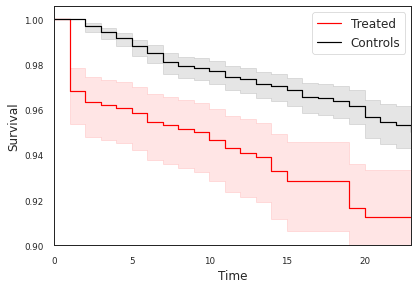

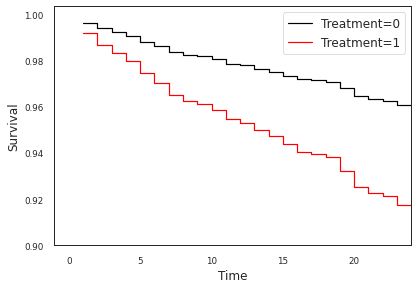

In [13]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
ylimDB = [0.9]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title, ylim = ylimDB)

In [14]:
lrsumm

test_statistic         p   -log2(p)
Diabetes       23.666579  0.000001  19.735531

In [15]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               0.929           0.505        1.839    0.066
Total Cost                        0.013           0.033        0.383    0.702
Gender                            0.063           0.169        0.370    0.712
Tobacco Use                      -0.005           0.258       -0.019    0.985
Pressure                        -14.309        1514.124       -0.009    0.992
Obesity                           0.250           0.162        1.540    0.123
Hypertension                      0.111           0.198        0.562    0.574
Hypothyroid                      -0.133           0.230       -0.576    0.564
Disease Count                     1.805           0.721        2.504    0.012
Acute Care 2 Months               0.777           0.357        2.177    0.029
Acute Care 6 Months              -0.107           0.862       -0.125    0.901
Inpatient Visits 6 Months        -0.233           0.731       -0.319    0.750
Emergency Vistits 6 Months       -0.039           0.801       -0.048    0.961
Line of Bussiness                -0.090           0.328       -0.276    0.783
Treatment                         0.767           0.159        4.832    0.000

### ER

In [16]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [17]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace, onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])

survCo = data[1].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 7.09 s, sys: 26.9 ms, total: 7.12 s
Wall time: 7.12 s


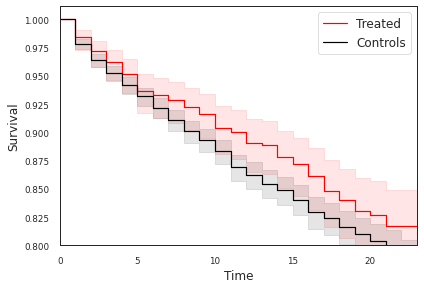

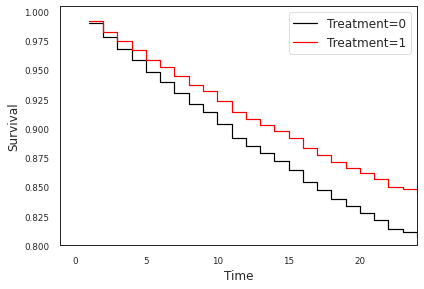

In [18]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
ylimER = [0.8]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, path_figs2=path_figs2, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimER)

In [19]:
lrsumm

test_statistic         p  -log2(p)
Emergency Visits        2.879915  0.089691  3.478897

In [20]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -1.099           0.252       -4.361    0.000
Total Cost                        0.083           0.018        4.589    0.000
Gender                           -0.067           0.088       -0.755    0.450
Tobacco Use                       0.223           0.115        1.933    0.053
Pressure                         -0.040           0.717       -0.056    0.956
Obesity                          -0.042           0.083       -0.510    0.610
Hypertension                      0.055           0.095        0.586    0.558
Hypothyroid                      -0.366           0.129       -2.837    0.005
Disease Count                     0.783           0.383        2.044    0.041
Acute Care 2 Months               1.367           0.146        9.373    0.000
Acute Care 6 Months              -0.537           0.286       -1.876    0.061
Inpatient Visits 6 Months        -0.113           0.203       -0.559    0.576
Emergency Vistits 6 Months        0.976           0.263        3.712    0.000
Line of Bussiness                -0.369           0.141       -2.614    0.009
Treatment                        -0.238           0.104       -2.294    0.022

### IP

In [21]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [22]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 7.15 s, sys: 24.9 ms, total: 7.18 s
Wall time: 7.22 s


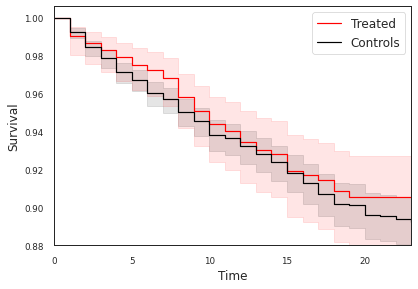

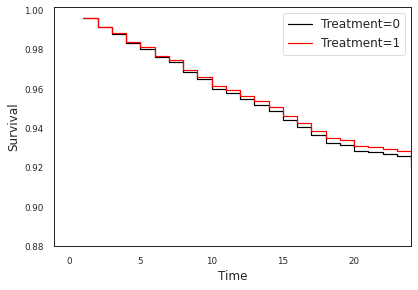

In [23]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
ylimIP =  [0.88]

lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylimIP)

In [24]:
lrsumm

test_statistic         p  -log2(p)
Inpatient Visits        0.034603  0.852431  0.230346

In [25]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                               0.361           0.375        0.963    0.336
Total Cost                        0.198           0.030        6.692    0.000
Gender                            0.150           0.118        1.273    0.203
Tobacco Use                       0.119           0.167        0.716    0.474
Pressure                          0.017           0.723        0.024    0.981
Obesity                           0.167           0.113        1.480    0.139
Hypertension                      0.122           0.133        0.916    0.360
Hypothyroid                      -0.254           0.170       -1.494    0.135
Disease Count                     2.374           0.463        5.124    0.000
Acute Care 2 Months               1.255           0.187        6.707    0.000
Acute Care 6 Months              -1.133           0.283       -4.002    0.000
Inpatient Visits 6 Months         1.425           0.250        5.688    0.000
Emergency Vistits 6 Months        0.784           0.231        3.391    0.001
Line of Bussiness                -0.329           0.199       -1.651    0.099
Treatment                        -0.041           0.137       -0.296    0.767

### Acute Care IP OR ER

In [26]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [27]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 7.12 s, sys: 12.2 ms, total: 7.13 s
Wall time: 7.13 s


In [28]:
survTr[survTr.E >0]

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  \
1    2619378   3  1      0     0.0     0.0        1               78   
2    2621187  11  1      0     0.0     0.0        2               78   
3    2623521  28  1      0     0.0     0.0        0               77   
13   2649799   8  1      0     0.0     0.0        1               74   
14   2651688   4  1      0     0.0     0.0        0               74   
..       ...  .. ..    ...     ...     ...      ...              ...   
764  4351068   1  1      1     1.0     1.0        2               41   
787  4390059   4  1      0     0.0     0.0        0               47   
788  4391112  26  1      0     0.0     0.0        0               47   
794  5001236  16  1      0     0.0     0.0        0               60   
798  5003200   1  1      1     1.0     1.0        1               55   

     ALLOW_AMT  ALLOW_ER  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  \
1          399       0.0  ...       0      0.0      0.0     0    1         1   
2        13007       0.0  ...       0      0.0      0.0     0    1         1   
3            0       0.0  ...       0      0.0      0.0     0    1         0   
13         333       0.0  ...       0      0.0      0.0     1    1         1   
14         179       0.0  ...       0      0.0      0.0     0    1         1   
..         ...       ...  ...     ...      ...      ...   ...  ...       ...   
764       1808     992.0  ...       0      0.0      0.0     0    1         1   
787          2       0.0  ...       0      0.0      0.0     0    1         0   
788        149       0.0  ...       0      0.0      0.0     0    1         0   
794        374       0.0  ...       0      0.0      0.0     0    1         0   
798       3137    1298.0  ...       0      0.0      0.0     0    1         0   

     MEDICAID_LOB     MYR  PREGNANCY  Treatment  
1        Medicare  201910        0.0          1  
2        Medicare  202001        0.0          1  
3        Medicare  201903        0.0          1  
13       Medicare  202011        0.0          1  
14       Medicare  202011        0.0          1  
..            ...     ...        ...        ...  
764    Commercial  202011        0.0          1  
787    Commercial  202002        0.0          1  
788    Commercial  201904        0.0          1  
794    Commercial  202002        0.0          1  
798    Commercial  202005        0.0          1  

[151 rows x 94 columns]

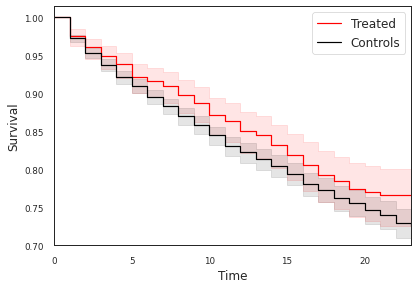

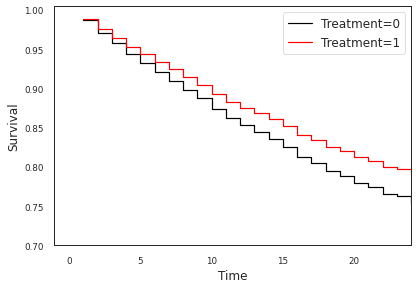

In [29]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
ylim = [0.7]
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title, ylim = ylim)

In [30]:
lrsumm

test_statistic         p  -log2(p)
Acute Care        1.889431  0.169266  2.562634

In [31]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.601           0.224       -2.684    0.007
Total Cost                        0.112           0.017        6.793    0.000
Gender                           -0.027           0.077       -0.347    0.729
Tobacco Use                       0.179           0.103        1.730    0.084
Pressure                          0.092           0.586        0.157    0.875
Obesity                          -0.000           0.072       -0.006    0.995
Hypertension                      0.036           0.083        0.432    0.666
Hypothyroid                      -0.330           0.110       -2.988    0.003
Disease Count                     1.168           0.332        3.523    0.000
Acute Care 2 Months               1.399           0.127       11.038    0.000
Acute Care 6 Months               0.072           0.234        0.307    0.759
Inpatient Visits 6 Months        -0.153           0.198       -0.774    0.439
Emergency Vistits 6 Months        0.253           0.217        1.164    0.245
Line of Bussiness                -0.430           0.124       -3.462    0.001
Treatment                        -0.180           0.089       -2.008    0.045

### Acute Care  diff and diff calculation

In [32]:
%%time
from utils import findDate, filter_first_date
from data_functions import make_date_to_MYR

pmpm = pd.read_pickle('../Pre_Matching_DATA/'+'pmpm.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

CPU times: user 11.9 s, sys: 13.6 s, total: 25.5 s
Wall time: 1min 8s


In [33]:
%%time
tr = treated.copy().drop(columns = ['Treatment'], axis = 1)
cr = controls.copy().drop(columns = ['Treatment'], axis = 1)

treated2 = (filter_first_date(findDate(tr.copy(), pmpm.copy(), 6))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls2 = (filter_first_date(findDate(cr.copy(), pmpm.copy(), 6))).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

controls2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
treated2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
treated2['Treatment'] = 1
controls2['Treatment'] = 0
data2 = [treated2,  controls2]
for d in data2:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

CPU times: user 20 s, sys: 3.44 s, total: 23.5 s
Wall time: 23.5 s


In [34]:
treated2.shape, controls2.shape

In [35]:
treated.PERS_ID.unique().shape, controls.PERS_ID.unique().shape

In [36]:
treated2.PERS_ID.unique().shape, controls2.PERS_ID.unique().shape

In [37]:
%%time
times = [0]
onset = 'Acute-bin'


survTr = treated2.copy().groupby('PERS_ID').apply(survival_diabetes,  grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls2.copy().groupby('PERS_ID').apply(survival_diabetes, grace = times[0], onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
# curves.append((survTr, survCo))

CPU times: user 6.64 s, sys: 30.6 ms, total: 6.67 s
Wall time: 6.67 s


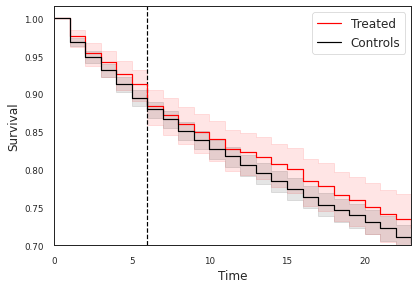

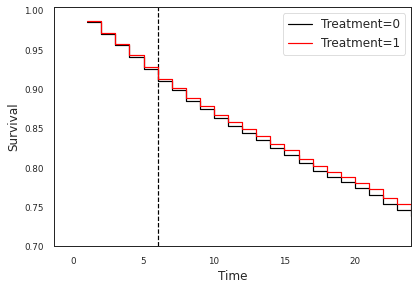

In [38]:
fittedDD, rmstAcuteDD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                      model = model, model_type = model_type,
                      model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                     log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care_dd'
ylim = [0.7]
lrsummDD, ax1, ax2, summDD = make_results(fittedDD, survTr, survCo, path_tabs = path_tabs, 
                                  path_figs=path_figs,  path_figs2=path_figs2,  surv_model = CoxPHFitter,
                                  model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                  filter_cols = filter_cols2, summary_names = summary_names,
                                 log_normalize = log_normalize, normalize = normalize,
                                 kaplan_plot_params=kaplan_plot_params,
                                  timeline = timeline,
                                  outcome_title = 0, ylim = ylim, ver_line = True, ver_line_val = 6)

In [39]:
lrsummDD

test_statistic         p  -log2(p)
Acute Care_dd        1.129262  0.287933  1.796196

In [40]:
summDD

Coefficient  Standard Error  z-statistic  p-value
Age                              -0.904           0.188       -4.804    0.000
Total Cost                        0.078           0.013        5.918    0.000
Gender                           -0.119           0.068       -1.756    0.079
Tobacco Use                      -0.064           0.098       -0.653    0.514
Pressure                          0.299           0.515        0.581    0.561
Obesity                          -0.155           0.066       -2.332    0.020
Hypertension                     -0.273           0.074       -3.700    0.000
Hypothyroid                      -0.412           0.100       -4.114    0.000
Disease Count                     1.771           0.296        5.984    0.000
Acute Care 2 Months               1.312           0.110       11.890    0.000
Acute Care 6 Months               0.686           0.269        2.547    0.011
Inpatient Visits 6 Months        -0.331           0.222       -1.492    0.136
Emergency Vistits 6 Months       -0.405           0.256       -1.585    0.113
Line of Bussiness                -0.589           0.108       -5.440    0.000
Treatment                        -0.036           0.080       -0.449    0.653

### Load all Log Rank Sums in a matrix

In [41]:
from pathlib import Path
pp = Path(path_tabs)

df2 = None
for i, ff in enumerate(pp.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)

df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['LogRank Statistic', 'LogRank Test P-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care', 'Acute Care DD']
for month, i in zip([6,12,18,24], [0,1,2,3]):
    df2['RMST Difference After '+ str(month)+' Months'] = np.array([rmstD[i], rmstER[i], rmstIP[i], rmstAcute[i], rmstAcuteDD[i]])
df2.to_csv(path_tabs+'all_logrank.csv')

In [42]:
df2.round(2)

LogRank Statistic  LogRank Test P-value  \
Diabetes                      23.67                  0.00   
Emergency Visits               2.88                  0.09   
Inpatient Vistis               0.03                  0.85   
Acute Care                     1.89                  0.17   
Acute Care DD                  1.13                  0.29   

                  RMST Difference After 6 Months  \
Diabetes                                   -0.16   
Emergency Visits                            0.04   
Inpatient Vistis                            0.02   
Acute Care                                  0.05   
Acute Care DD                               0.05   

                  RMST Difference After 12 Months  \
Diabetes                                    -0.33   
Emergency Visits                             0.16   
Inpatient Vistis                             0.07   
Acute Care                                   0.22   
Acute Care DD                                0.11   

                  RMST Difference After 18 Months  \
Diabetes                                    -0.55   
Emergency Visits                             0.34   
Inpatient Vistis                             0.09   
Acute Care                                   0.37   
Acute Care DD                                0.24   

                  RMST Difference After 24 Months  
Diabetes                                    -0.80  
Emergency Visits                             0.49  
Inpatient Vistis                             0.14  
Acute Care                                   0.54  
Acute Care DD                                0.36